In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Load the fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Set the model to evaluation mode
model.eval()


# Function to make predictions and return sentiment label
def predict(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        # Get model outputs
        outputs = model(**inputs)

        logits = outputs.logits

        # Apply softmax to get probabilities
        probabilities = torch.softmax(logits, dim=-1)

        # Get the predicted class (0 for negative, 1 for positive)
        predicted_class = torch.argmax(probabilities, dim=1).item()

        # Map the class to the corresponding label
        label = "positive" if predicted_class == 1 else "negative"

    return label, probabilities


text = "The performance by the lead actor was simply outstanding and very moving!"

# Get predictions and label
label, probabilities = predict(text)
print("Predicted Sentiment:", label)
print("Probabilities:", probabilities)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Predicted Sentiment: positive
Probabilities: tensor([[1.2192e-04, 9.9988e-01]])


In [ ]:
pip install torch torchvision transformers

Prediction: Dog


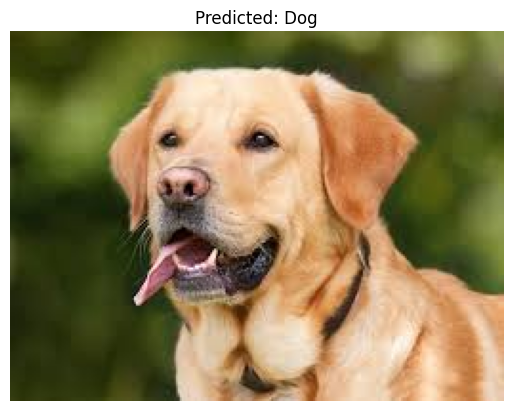

In [ ]:
          import torch
          import torch.nn as nn
          import torch.nn.functional as F
          from torchvision import models, transforms
          from transformers import BertTokenizer, BertModel
          from PIL import Image
          import matplotlib.pyplot as plt

          # Define a multimodal model combining text and image inputs
          class MultimodalModel(nn.Module):
              def __init__(self, text_model, image_model, hidden_dim=256, num_classes=3):
                  super(MultimodalModel, self).__init__()
                  self.text_model = text_model
                  self.image_model = image_model

                  # Define a fully connected layer to combine features
                  self.fc1 = nn.Linear(hidden_dim, hidden_dim)
                  self.fc2 = nn.Linear(hidden_dim, num_classes)

              def forward(self, text_input, text_attention_mask, image_input):
                  # Process text input
                  text_output = self.text_model(input_ids=text_input, attention_mask=text_attention_mask)[0][:, 0, :]  # Get the [CLS] token output

                  # Process image input
                  image_output = self.image_model(image_input)

                  # Flatten the image output to match text output dimension
                  image_output = image_output.view(image_output.size(0), -1)

                  # Combine features
                  combined_output = torch.cat((text_output, image_output), dim=1)

                  # Pass through fully connected layers
                  x = F.relu(self.fc1(combined_output))
                  x = self.fc2(x)
                  return x

          # Load pre-trained models
          text_model_name = 'bert-base-uncased'
          text_model = BertModel.from_pretrained(text_model_name)
          tokenizer = BertTokenizer.from_pretrained(text_model_name)

          image_model = models.resnet50(pretrained=True)
          num_ftrs = image_model.fc.in_features
          image_model.fc = nn.Identity()  # Remove the final classification layer

          # Hidden dimension is the sum of BERT hidden size and ResNet50 output size
          hidden_dim = 768 + num_ftrs  # BERT hidden size + ResNet50 output size
          model = MultimodalModel(text_model=text_model, image_model=image_model, hidden_dim=hidden_dim, num_classes=3)

          # Define image and text preprocessing
          image_transform = transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          ])

          def process_text(text):
              tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
              return tokens['input_ids'], tokens['attention_mask']

          def process_image(image_path):
              image = Image.open(image_path).convert('RGB')
              return image_transform(image).unsqueeze(0)

          # Define class labels
          class_labels = ["Cat", "Dog"]

          # Example usage
          text_input = "This is a photo of a dog."
          image_path = "/content/download (2).jpeg"

          # Process inputs
          text_tensor, attention_mask = process_text(text_input)
          image_tensor = process_image(image_path)

          # Make prediction
          model.eval()
          with torch.no_grad():
              prediction = model(text_tensor, attention_mask, image_tensor)
              predicted_class = torch.argmax(prediction, dim=1).item()

          print("Prediction:", class_labels[predicted_class])

          # Display the image and prediction
          image = Image.open(image_path).convert('RGB')
          plt.imshow(image)
          plt.title(f"Predicted: {class_labels[predicted_class]}")
          plt.axis('off')
          plt.show()
